In [1]:
%load_ext autoreload
%autoreload 2

from source.read_HAR_dataset import read_har_dataset, har_dimensions, har_activities, har_activities_map, har_ind_IDS
from source.utils import  filter_dimensions
from source.tserie import TSerie
from source.utils import classify_dataset
from itertools import chain, combinations
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn import svm
from source.utils import idsStd
from sklearn import metrics
import numpy as np
from sklearn import svm
import umap
from imblearn.under_sampling import RandomUnderSampler
from source.augmentation import  * 
# from cuml.datasets import make_blobs
from cuml.neighbors import NearestNeighbors
from cuml.manifold import UMAP
from cuml.cluster import DBSCAN


sys.path.insert(0, '/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# Z_SCORE_NORM = True
NORM = 1 # 0: No normalization, 1: centering 2: z_score_norm
DATASET = 'HAR-UML20'
KFOLDS = 10
N_TESTS = 1
METRIC  = 'braycurtis'
RESULTS_PATH = 'outputs/augmentation/'
# AUGMENTATIONS = ['rotation', 'permutation', 'time_warp', 'magnitude_warp', 'scaling', 'jitter']
# AUGMENTATIONS = ['none']
# AUGMENTATIONS = ['scaling']
ALL_AUGMENTATIONS = ['none', 'rotation', 'permutation', 'time_warp', 'magnitude_warp', 'scaling', 'jitter']
# ALL_AUGMENTATIONS = ['none', 'rotation', 'rotation', 'rotation', 'rotation', 'rotation', 'rotation']
# ALL_AUGMENTATIONS = ['none'] * 7
# AUGMENTATIONS = ['magnitude_warp']
N_COMPONENTS = 32
REPEATS_PER_AUGMENTATION = 1
INCLUDE_ORIGINAL = True
# N_DIMS_NAMES = ['Acc', 'Gyro', 'Mag']
N_DIMS_NAMES = ['Acc', 'Gyro']
# N_DIMS_NAMES = ['Acc']
N_DIMENSIONS = [
    [
        'Accelerometer-X',	
        'Accelerometer-Y',	
        'Accelerometer-Z',
    ],
    [
        'Gyrometer-X',
        'Gyrometer-Y',
        'Gyrometer-Z',
    ],
    # [
    #     'Magnetometer-X',
    #     'Magnetometer-Y',
    #     'Magnetometer-Z'
    # ]
]

AUG_RATIO = 2


In [2]:
class FeatureExtractor:
    def __init__(self, n_components, n_neighbors):
        self.reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, n_epochs=2000)
        self.nearNeigh = NearestNeighbors(n_neighbors=n_neighbors, metric=METRIC)

    def fit_transform(self, X, y=None):
        self.nearNeigh.fit(X)
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.fit_transform(X, y=y, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings
    
    def transform(self, X):
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.transform(X, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings
def augmentData(X, y, I, augmentation, repeat = 3):
    X_out = []
    y_out = []
    I_out = []
    for i in range(repeat):
        if augmentation == 'rotation':
            augmented = rotation(X, angle_range=[-np.pi/4, np.pi/4])
            # augmented = rotation(X, angle_range=[-np.pi/64, np.pi/64])
        elif augmentation == 'permutation':
            augmented = permutation(X)
        elif augmentation == 'time_warp':
            augmented = time_warp(X, sigma=0.03)
        elif augmentation == 'magnitude_warp':
            augmented = magnitude_warp(X, sigma=0.015, knot=4)
        elif augmentation == 'scaling':
            augmented = scaling(X, sigma=0.05)
        elif augmentation == 'jitter':
            augmented = jitter(X, sigma=0.005)
        # elif augmentation == 'magnitude_pert':
        #     augmented = magnitude_pert(X, prange=[0, 1])
        else:
            augmented = X
        if len(X_out) == 0:
            X_out = augmented
            y_out = y
            I_out = I
        else:
            X_out = np.concatenate((X_out, augmented), axis=0)
            y_out = np.concatenate((y_out, y), axis=0)
            I_out = np.concatenate((I_out, I), axis=0)
    return X_out, y_out, I_out

def augment(X, y, I, augmentations, repeats_per_augmentation=1, include_original=False):
    X_aug = []
    y_aug = []
    I_aug = []
    if include_original:
        X_aug = X
        y_aug = y
        I_aug = I
    for augmentation in augmentations:
        curr_X_aug, curr_y_aug, curr_I_aug = augmentData(X, y, I, augmentation, repeat=repeats_per_augmentation)
        if len(X_aug) == 0:
            X_aug = curr_X_aug
            y_aug = curr_y_aug
            I_aug = curr_I_aug
        else:
            X_aug = np.concatenate((X_aug, curr_X_aug), axis=0)
            y_aug = np.concatenate((y_aug, curr_y_aug), axis=0)
            I_aug = np.concatenate((I_aug, curr_I_aug), axis=0)
    return X_aug, y_aug, I_aug
def random_augmentation(X, y, I, n_times = 1):
    n = len(X)
    new_n = n * n_times
    ind = np.random.randint(0, n, new_n)
    augmentations = ['rotation', 'permutation', 'time_warp', 'magnitude_warp', 'scaling', 'jitter']
    per_trans_n = new_n // len(augmentations )
    
    all_X = []
    all_y = []
    all_I = []
    for i in range(len(augmentations)):
        n_ind = np.random.randint(0, new_n, per_trans_n)
        sub_X = X[ind[n_ind]]
        sub_y = y[ind[n_ind]]
        sub_I = I[ind[n_ind]]
        
        
        sub_aug, sub_y, sub_I = augment(sub_X, sub_y, sub_I, [augmentations[i]], repeats_per_augmentation=1, include_original=False)
        
        if len(all_X) == 0:
            all_X = sub_aug
            all_y = sub_y
            all_I = sub_I
        else:
            all_X = np.concatenate([all_X, sub_aug], axis = 0)
            all_y = np.concatenate([all_y, sub_y], axis = 0)
            all_I = np.concatenate([all_I, sub_I], axis = 0)
    return all_X, all_y, all_I
    

def minoritySampling(X, y):
    rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
    N, T, D = X.shape
    X_temp = X.reshape([N, T * D])
    X_temp, y = rus.fit_resample(X_temp, y)
    X = X_temp.reshape([X_temp.shape[0], T, D])
    return X, y


activities_map = har_activities_map
# activities_map = {
#     0: "Sedentary",
#     1: "Walking",
#     2: "Running",
#     3: "Downstairs",
#     4: "Upstairs"
# }
def load_data(k):
    all_ids = har_ind_IDS
    test_ids = all_ids[k: k + N_TESTS]
    train_ids = all_ids[:k] + all_ids[k + N_TESTS:]        
    
    data = read_har_dataset('./datasets/HAR-UML20/', train_ids=train_ids, test_ids=test_ids, val_ids=[], cache=True)
    ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']
    # ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']
    ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']
    
    
    

    all_dimensions = har_dimensions
    activities_map = har_activities_map
    
    # y_train[y_train==0] = 0
    # y_train[y_train==1] = 0
    # y_train[y_train==2] = 0
    # y_test[y_test==0] = 0
    # y_test[y_test==1] = 0
    # y_test[y_test==2] = 0

    # for i in range(3, len(har_activities)):
    #     y_train[y_train==i] = i - 2
    #     y_test[y_test==i] = i - 2
    
    ind_std_train = idsStd(train_ids , X_train, I_train)
    ind_std_test = idsStd(test_ids, X_test, I_test)
    
    unique, counts = np.unique(y_train, return_counts=True)
    unique, counts = np.unique(y_test, return_counts=True)
    
    
    I_train = np.expand_dims(I_train, axis=1)
    I_test = np.expand_dims(I_test, axis=1)
    ltrain = np.arange(len(y_train))
    ltest = np.arange(len(y_test))
    
    X_train, zlabels_train = minoritySampling(X_train, ltrain)
    X_test, zlabels_test = minoritySampling(X_test, ltest)
    
    y_train = y_train[ltrain]
    I_train = I_train[ltrain]
    y_test = y_test[ltest]
    I_test = I_test[ltest]
    
    y_train = train_kcal_MET[ltrain, 1]
    y_test = test_kcal_MET[ltest, 1]
    
    return X_train, y_train, I_train, X_test, y_test, I_test


In [3]:

# from source.torch_utils import getContrastiveFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

firstTimeSave = True
storage = MTSStorage('har_augmentations')
# storage.delete()
storage.load()


components_map = {}

for k in range(KFOLDS):
    print('FOLD: {}'.format(k))
    # ------------------------ Reading the dataset ------------------------
    X_train, y_train, I_train, X_test, y_test, I_test = load_data(k)
    # ---------------------------------------------------------------------

    
    train_ys = []
    
    # All test embeddings including original in ALL_AUGMENTATIONS order
    test_embeddings = []
    # Can either be the original or the mixture of original and augmented
    train_embeddings = []
    
    
    
    mts_train = TSerie(X = X_train, y = y_train, I = I_train,  classLabels=activities_map)
    mts_test = TSerie(X = X_test, y = y_test, I = I_test,  classLabels=activities_map)
    
    minl, maxl = mts_train.minMaxNormalization()
    mts_test.minMaxNormalization(minl=minl, maxl=maxl)
    
    if AUG_RATIO == 0:
        X_train_all = mts_train.X
        y_train_all = mts_train.y
        I_train_all = mts_train.I
    else:
        X_rand_aug, y_rand_aug, I_rand_aug = random_augmentation(mts_train.X, mts_train.y, mts_train.I, n_times=AUG_RATIO)
        X_train_all = np.concatenate([X_rand_aug, mts_train.X], axis=0)
        y_train_all = np.concatenate([y_rand_aug, mts_train.y], axis=0)
        I_train_all = np.concatenate([I_rand_aug, mts_train.I], axis=0)
    
    # print('ALL shape')
    # print(X_train_all.shape)
    # print('ALL y shape')
    # print(y_train_all.shape)
    
    # Training reducer
    if NORM == 1:
        mts_train.center()
        mts_test.center()
    elif NORM == 2:
        mts_train.znorm()
        mts_test.znorm()
    
    mts_train.X_o = mts_train.X
    mts_test.X_o = mts_test.X
    
    # Saving augmentations
    test_tranformations = [
        augment(mts_test.X, mts_test.y, mts_test.I,  repeats_per_augmentation = 1, augmentations = [ALL_AUGMENTATIONS[i]], include_original = False)
        for i in range(len(ALL_AUGMENTATIONS))
    ]
    mts_train_t = TSerie(X = X_train_all, y = y_train_all, I = I_train_all, classLabels=activities_map)
    if NORM == 1:
        mts_train_t.center()
    elif NORM == 2:
        mts_train_t.znorm()
    mts_train_t.X_o = mts_train_t.X
    
    test_mts = {}
    for i in range(len(ALL_AUGMENTATIONS)):
        tranformation_name = ALL_AUGMENTATIONS[i]
        test_tranformations[i] = test_tranformations[i][0].copy()
        
        mts_test_t = TSerie(X = test_tranformations[i], y = mts_test.y, I = mts_test.I, classLabels=activities_map)
        if NORM == 1:
            mts_test_t.center()
        elif NORM == 2:
            mts_test_t.znorm()
        
        mts_test_t.X_o = mts_test_t.X
        test_mts[tranformation_name] = mts_test_t
    
    
    for t in range(len(N_DIMENSIONS)):
        dimensions = N_DIMENSIONS[t]    
        mts_train.X = filter_dimensions(mts_train.X_o, har_dimensions, dimensions)
        mts_test.X = filter_dimensions(mts_test.X_o, har_dimensions, dimensions)
        
        
        mts_train.folding_features_v2()
        mts_test.folding_features_v2()

        #  TRAIN PROJECTOR
        n_neighbors = 15
        reducer = FeatureExtractor(N_COMPONENTS, n_neighbors)        
        embeddings_train = reducer.fit_transform(mts_train.features, y=mts_train.y)
        
        
        mts_train_t.X = filter_dimensions(mts_train_t.X_o, har_dimensions, dimensions)
        mts_train_t.folding_features_v2()
        mts_train_t.features = reducer.transform(mts_train_t.features)
        train_map = mts_train_t.features
        
        
        test_map = {}
        for i in range(len(ALL_AUGMENTATIONS)):
            tranformation_name = ALL_AUGMENTATIONS[i]
            mts_test_t = test_mts[tranformation_name]
            mts_test_t.X = filter_dimensions(mts_test_t.X_o, har_dimensions, dimensions)
            mts_test_t.folding_features_v2()
            mts_test_t.features = reducer.transform(mts_test_t.features)
            test_map[tranformation_name] = mts_test_t.features
        
        train_embeddings.append(train_map)
        test_embeddings.append(test_map)
        
    
    names_comb = []
    embeddings_comb = []
    for i, combo in enumerate(powerset(list(range(len(N_DIMS_NAMES)))), 1):
        indexes = list(combo)
        name = ''
        train_embedding = []
        # train_y = {}
        test_embedding = {}
        if len(indexes) == 0:
            continue
        for ind in indexes:
            name = name + ' ' + N_DIMS_NAMES[ind]
            if len(test_embedding) == 0:
                for aug in ALL_AUGMENTATIONS:
                    test_embedding[aug] = test_embeddings[ind][aug]
            else:
                for aug in ALL_AUGMENTATIONS:
                    test_embedding[aug] = np.concatenate([test_embedding[aug], test_embeddings[ind][aug]], axis=1)        

            print(train_embeddings[ind].shape)
            if len(train_embedding) == 0:
                train_embedding = train_embeddings[ind]
            else:
                train_embedding = np.concatenate([train_embedding, train_embeddings[ind]], axis=1)
        
        names_comb.append(name)
        embeddings_comb.append((train_embedding, test_embedding))
    
    print('Classifying')
    for j in range(len(names_comb)):
        name = names_comb[j]
        # clf = AdaBoostClassifier()
        # clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
        clf = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor')
        # clf = svm.SVC()
        
        train_feat = []
        train_y = y_train_all
        
        train_feat, test_feat_map = embeddings_comb[j]
        
        clf.fit(train_feat, train_y)
        
        pred_train = clf.predict(train_feat)
        f1_tr = metrics.mean_absolute_error(train_y, pred_train)
        
        f1_scores = [f1_tr]
        
        
        all_pred = []
        
        first_done = False
        for aug in ALL_AUGMENTATIONS:
            test_feat = test_feat_map[aug]
            pred_test = clf.predict(test_feat)
            f1_te = metrics.mean_absolute_error(y_test, pred_test)
            f1_scores.append(f1_te)
            
            if first_done:
                if len(all_pred) == 0:
                    all_pred = np.expand_dims(pred_test, axis=1)
                    
                else:
                    all_pred = np.concatenate([all_pred, np.expand_dims(pred_test, axis=1)], axis = 1)
                
            first_done = True
        
        vote_out = np.zeros(all_pred.shape[0])
        # for l in range(all_pred.shape[0]):
        #     counts = np.bincount(all_pred[l])
        #     vote_out[l] = np.argmax(counts)
        f1_vot = metrics.mean_absolute_error(y_test, vote_out)
        f1_scores.append(f1_vot)
        
        if name not in components_map:
            components_map[name] = [f1_scores]
        else:
            components_map[name] = components_map[name] + [f1_scores]
    print('Classifying done')


        
    
    
    

FOLD: 0
Train IDS: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Test IDS: [0]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(22050, 32)
(22050, 32)
(22050, 32)
(22050, 32)
Classifying
Classifying done
FOLD: 1
Train IDS: [0, 2, 3, 4, 5, 6, 7, 8, 9]
Test IDS: [1]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(22050, 32)
(22050, 32)
(22050, 32)
(22050, 32)
Classifying
Classifying done
FOLD: 2
Train IDS: [0, 1, 3, 4, 5, 6, 7, 8, 9]
Test IDS: [2]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(22050, 32)
(22050, 32)
(22050, 32)
(22050, 32)
Classifying
Classifying done
FOLD: 3
Train IDS: [0, 1, 2, 4, 5, 6, 7, 8, 9]
Test IDS: [3]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(22050, 32)
(22050, 32)
(22050, 32)
(22050, 32)
Classifying
Classifying done
FOLD: 4
Train IDS: [0, 1, 2, 3, 5, 6, 7, 8, 9]
Test IDS: [4]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(22050, 32)
(22050, 32)
(22050, 32)
(22050, 32)
Classifying
Classifying done
FOLD: 5
Train IDS: [0, 1, 2, 3, 4, 6, 7, 8, 9]
Test IDS: [5]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(23310, 32)
(23310, 32)
(23310, 32)
(23310, 32)
Classifying
Classifying done
FOLD: 6
Train IDS: [0, 1, 2, 3, 4, 5, 7, 8, 9]
Test IDS: [6]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(23310, 32)
(23310, 32)
(23310, 32)
(23310, 32)
Classifying
Classifying done
FOLD: 7
Train IDS: [0, 1, 2, 3, 4, 5, 6, 8, 9]
Test IDS: [7]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(23310, 32)
(23310, 32)
(23310, 32)
(23310, 32)
Classifying
Classifying done
FOLD: 8
Train IDS: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Test IDS: [8]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(23310, 32)
(23310, 32)
(23310, 32)
(23310, 32)
Classifying
Classifying done
FOLD: 9
Train IDS: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Test IDS: [9]
Val IDS: []
Loading dataset from cache...


/home/texs/Documentos/Repositories/mts_feature_learning/source/augmentation.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(23310, 32)
(23310, 32)
(23310, 32)
(23310, 32)
Classifying
Classifying done


 Acc & 0.29±0.01 & 0.68±0.16 & 0.68±0.16 & 0.76±0.16 & 0.69±0.16 & 0.68±0.15 & 0.68±0.15 & 0.70±0.15 & 3.24±0.38
 Gyro & 0.30±0.02 & 0.74±0.18 & 0.75±0.20 & 0.79±0.22 & 0.76±0.19 & 0.75±0.18 & 0.75±0.19 & 0.99±0.21 & 3.24±0.38
 Acc Gyro & 0.20±0.01 & 0.69±0.18 & 0.68±0.18 & 0.73±0.19 & 0.69±0.17 & 0.69±0.18 & 0.68±0.18 & 0.72±0.18 & 3.24±0.38


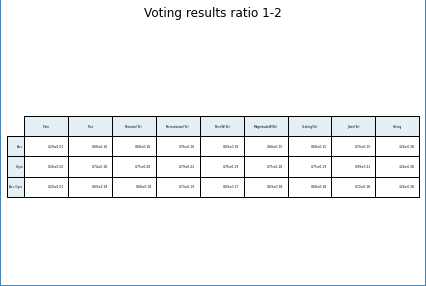

In [4]:
import csv
from source.utils import plotMatResult

row_names = []
column_names = ['Train', 'Test', 'Rotation(Te)', 'Permutation(Te)', 'TimeW(Te)', 'MagnitudeW(Te)', 'Scaling(Te)', 'Jitter(Te)', 'Voting']
mat_data = []

# path = os.path.join(RESULTS_PATH, 'Umap_mult_{}.csv'.format('_'.join(AUGMENTATIONS)))
path = os.path.join(RESULTS_PATH, 'Umap_mult.csv')
with open(path, 'w', newline='') as csvfile:
    row = ['Sensors', 'f1 train', 'f1 test']
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(row)
    for name in names_comb:
        row_names.append(name)
        row = [name]
        f1_mean_tr = np.array([ f1[0] for f1 in components_map[name]]).mean()
        f1_stds_tr = np.array([ f1[0] for f1 in components_map[name]]).std()
        f1_mean_te = np.array([ f1[1] for f1 in components_map[name]]).mean()
        f1_stds_te = np.array([ f1[1] for f1 in components_map[name]]).std()
        f1_mean_te_rot = np.array([ f1[2] for f1 in components_map[name]]).mean()
        f1_stds_te_rot = np.array([ f1[2] for f1 in components_map[name]]).std()
        f1_mean_te_per = np.array([ f1[3] for f1 in components_map[name]]).mean()
        f1_stds_te_per = np.array([ f1[3] for f1 in components_map[name]]).std()
        f1_mean_te_tim = np.array([ f1[4] for f1 in components_map[name]]).mean()
        f1_stds_te_tim = np.array([ f1[4] for f1 in components_map[name]]).std()
        f1_mean_te_mag = np.array([ f1[5] for f1 in components_map[name]]).mean()
        f1_stds_te_mag = np.array([ f1[5] for f1 in components_map[name]]).std()
        f1_mean_te_sca = np.array([ f1[6] for f1 in components_map[name]]).mean()
        f1_stds_te_sca = np.array([ f1[6] for f1 in components_map[name]]).std()
        f1_mean_te_jit = np.array([ f1[7] for f1 in components_map[name]]).mean()
        f1_stds_te_jit = np.array([ f1[7] for f1 in components_map[name]]).std()
        f1_mean_te_vot = np.array([ f1[8] for f1 in components_map[name]]).mean()
        f1_stds_te_vot = np.array([ f1[8] for f1 in components_map[name]]).std()
        
        row = [
            name, 
            '{:.2f}±{:.2f}'.format(f1_mean_tr, f1_stds_tr), 
            '{:.2f}±{:.2f}'.format(f1_mean_te, f1_stds_te), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_rot, f1_stds_te_rot), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_per, f1_stds_te_per), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_tim, f1_stds_te_tim), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_mag, f1_stds_te_mag), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_sca, f1_stds_te_sca), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_jit, f1_stds_te_jit), 
            '{:.2f}±{:.2f}'.format(f1_mean_te_vot, f1_stds_te_vot), 
        ]
        print(' & '.join(row))
        mat_data.append(row[1:])
        spamwriter.writerow(row)

if NORM == 1:
    footer = 'Data centered along x-axis'
if NORM == 2:
    footer = 'Z score normalization'
else:
    footer = ''
plotMatResult('Voting results ratio 1-{}'.format(AUG_RATIO), footer, row_names, column_names, mat_data, plot_fig=True, save_fig=True, file_name='met_ratio_1_{}_{}.png'.format(AUG_RATIO, footer))

In [5]:
# mask = y_test <= 1.5
# mask = np.logical_and( y_test > 1.5 , y_test <= 3 )
# mask = np.logical_and( y_test > 3 , y_test <= 6 )
# mask =  y_test > 6
# print(y_test[mask].shape)
# metrics.mean_absolute_error(y_test[mask], pred_test[mask])